# Pose Linear Metrics Statistical Analysis

This notebook performs comprehensive statistical analysis on all pose linear metrics using mixed-effects models and generates publication-ready figures.

## Important
Before using this notebook:
1. Download the raw pose data
2. Run `process_pose_data.py`

## Setup and Imports

To start, let's import relevant libraries and set the metrics for analysis:

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Ensure root directory is in the path for imports
sys.path.append('..')  
from stats_figures import run_rpy2_lmer, barplot_ax
import statsmodels.formula.api as smf

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


## Load Data

Load and optionally combine data across different methods (original vs. procrustes aligned data):

In [2]:
# Get processed data for further analysis
data_dir = Path("data") / "processed" / "linear_metrics"
methods_to_load = ["original", "procrustes_global", "procrustes_participant"]

# Load and concatenate all pose linear metrics files
pose_dfs = []
for method in methods_to_load:
    file_path = data_dir / f"{method}_linear.csv"
    if file_path.exists():
        df = pd.read_csv(file_path)
        df["method"] = method

        # Standardise participant ID column name
        if "participant" in df.columns:
            df = df.rename(columns={"participant": "participant_id"})

        pose_dfs.append(df)
        print(f"Loaded {method}: {df.shape[0]} rows")
    else:
        print(f"Warning: {file_path.name} not found")

if not pose_dfs:
    raise FileNotFoundError("No pose linear metrics files found.")

pose_metrics_df = pd.concat(pose_dfs, ignore_index=True)
print(f"Combined DataFrame shape: {pose_metrics_df.shape}")

Loaded original: 4647 rows
Loaded procrustes_global: 4647 rows
Loaded procrustes_participant: 4647 rows
Combined DataFrame shape: (13941, 46)


## Select Metrics for Analysis

In [3]:
# Option 1: Analyze ALL metrics (overrides other options if True)
ANALYZE_ALL_METRICS = False

# Option 2: Analyze specific metrics by name
SELECTED_METRICS = [
    # --- Head rotation metrics ---
    "head_rotation_rad_mean_abs_vel",
    "head_rotation_rad_rms",

    # --- Blink metrics ---
    "blink_aperture_mean_abs_vel",
    "blink_aperture_rms",

    # --- Mouth metrics ---
    "mouth_aperture_mean_abs_vel",
    "mouth_aperture_rms",

    # --- Pupil metrics ---
    "pupil_dx_rms",
    "pupil_dy_rms",
    "pupil_metric_rms",

    # --- Center face metrics ---
    "center_face_magnitude_rms",
    "center_face_x_rms",
    "center_face_y_rms",
]

## Load Session Info

Load session info for all participants and add relevant dependent variables to pose_metrics_df:

In [4]:
# Load session information
session_dir = Path("data") / "pose_data"
Session_Info = pd.read_csv(
    os.path.join(session_dir,"participant_info.csv")
)

# Add session_order string
if {"session01", "session02", "session03"}.issubset(Session_Info.columns):
    Session_Info["session_order"] = (
        Session_Info["session01"].str[0] +
        Session_Info["session02"].str[0] +
        Session_Info["session03"].str[0]
    )

session_order_numeric_map = {"LMH": 1, "LHM": 2}

# === Derive condition from participant_info ===
def get_condition(row):
    pid = int(row['participant_id'])
    # If session_number is already present, map directly
    if "session_number" in row and not pd.isna(row["session_number"]):
        session_col = f"session{int(row['session_number']):02d}"
        if session_col in Session_Info.columns:
            cond = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
            if len(cond) > 0:
                return cond[0]
    # Otherwise try matching to session01–03
    for s_num in [1, 2, 3]:
        session_col = f"session{s_num:02d}"
        if session_col in Session_Info.columns:
            cond_val = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
            if len(cond_val) > 0:
                # If this condition matches the pose row's 'condition' (if present), use this session
                if "condition" in row and str(row["condition"]).strip().upper() == str(cond_val[0]).strip().upper():
                    return cond_val[0]
    return None

# === Derive session_number by reverse lookup ===
def get_session_number(row):
    pid = int(row['participant_id'])
    row_cond = str(row.get('condition', '')).strip().upper()
    if row_cond in {"L", "M", "H"}:
        for s_num in [1, 2, 3]:
            session_col = f"session{s_num:02d}"
            if session_col in Session_Info.columns:
                val = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
                if len(val) > 0 and str(val[0]).strip().upper() == row_cond:
                    return s_num
    return np.nan

# Apply mapping
pose_metrics_df["condition"] = pose_metrics_df.apply(get_condition, axis=1)
pose_metrics_df["condition"] = pose_metrics_df["condition"].astype(str).str.strip().str.upper()
pose_metrics_df["session_number"] = pose_metrics_df.apply(get_session_number, axis=1)

# === Map session_order_numeric ===
if "session_order" in Session_Info.columns:
    session_info_numeric_map = Session_Info.set_index("Participant ID")["session_order"].map(session_order_numeric_map).to_dict()
    pose_metrics_df["session_order_numeric"] = pose_metrics_df["participant_id"].astype(int).map(session_info_numeric_map)

# Select metrics
metadata_cols = {
    "source", "participant_id", "condition", "window_index",
    "t_start_frame", "t_end_frame", "session_order", "session_order_numeric",
    "session_number", "method"
}

all_metric_cols = [c for c in pose_metrics_df.columns if c not in metadata_cols]

if ANALYZE_ALL_METRICS:
    # Use all metrics
    metric_cols = all_metric_cols

elif SELECTED_METRICS:
    # Use only explicitly listed metrics, warn for missing
    metric_cols = [col for col in SELECTED_METRICS if col in all_metric_cols]
    missing = [col for col in SELECTED_METRICS if col not in all_metric_cols]
    if missing:
        print(f"⚠️ Warning: {len(missing)} selected metrics not found:\n  - " + "\n  - ".join(missing))

else:
    raise ValueError("No metric selection mode specified. Enable one of: "
                     "ANALYZE_ALL_METRICS, SELECTED_METRICS, or METRIC_PATTERNS")

print(f"\n✅ Selected {len(metric_cols)} metrics for analysis:")
for m in metric_cols:
    print(f"  - {m}")


✅ Selected 12 metrics for analysis:
  - head_rotation_rad_mean_abs_vel
  - head_rotation_rad_rms
  - blink_aperture_mean_abs_vel
  - blink_aperture_rms
  - mouth_aperture_mean_abs_vel
  - mouth_aperture_rms
  - pupil_dx_rms
  - pupil_dy_rms
  - pupil_metric_rms
  - center_face_magnitude_rms
  - center_face_x_rms
  - center_face_y_rms


## Run Statistic Analyses and Plots

Run stats and make plots for the metrics of interest:

R callback write-console: Loading required package: lme4
  
R callback write-console: Loading required package: Matrix
  



Analyzing original normalization method...
Means for head_rotation_rad_mean_abs_vel:
  H: 0.189
  L: 0.186
  M: 0.185


R callback write-console: 
Attaching package: 'lmerTest'

  
R callback write-console: The following object is masked from 'package:lme4':

    lmer

  
R callback write-console: The following object is masked from 'package:stats':

    step

  
R callback write-console: Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'
  
R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4619' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4619)' or larger];
but be warned that this may result in large com


=== original_head_rotation_rad_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -16790

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5668 -0.5362 -0.1317  0.2940 10.3784 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.001154 0.03397 
 Residual                   0.001467 0.03831 
Number of obs: 4619, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.855e-01  1.548e-02  4.710e+01  11.980 6.65e-16 ***
condition.L            4.021e-03  1.424e-03  4.580e+03   2.824  0.00476 ** 
condition.Q            1.166e-03  1.428e-03  4.572e+03   0.817  0.41421    
session_order_numeric  4.006e-04  9.850e-03  4.705e+01   0.041  0.96773    
window

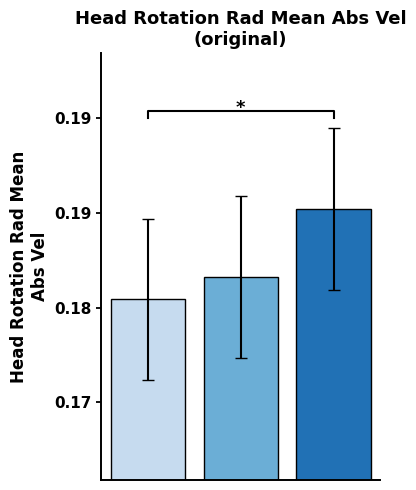

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4619' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4619' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for head_rotation_rad_rms:
  H: 0.062
  L: 0.060
  M: 0.067

=== original_head_rotation_rad_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -16341.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3159 -0.4189 -0.1234  0.2161 17.1298 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.001374 0.03707 
 Residual                   0.001616 0.04020 
Number of obs: 4619, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            3.117e-02  1.688e-02  4.709e+01   1.847  0.07110 .  
condition.L            4.873e-03  1.494e-03  4.579e+03   3.262  0.00112 ** 
condition.Q           -6.729e-03  1.498e-03  4.571e+03  -4.491 7.27e-06 ***
session_order_numeric  

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4619' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4619' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  


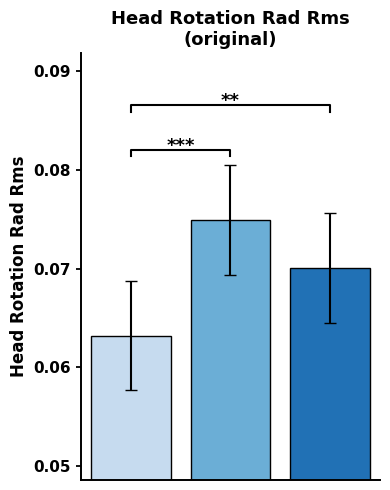

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for blink_aperture_mean_abs_vel:
  H: 0.177
  L: 0.170
  M: 0.172

=== original_blink_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -17612

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7191 -0.5235 -0.0378  0.4174  6.1930 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.001488 0.03857 
 Residual                   0.001244 0.03527 
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.664e-01  1.749e-02  4.709e+01   9.514 1.53e-12 ***
condition.L            7.022e-03  1.309e-03  4.597e+03   5.365 8.50e-08 ***
condition.Q           -3.501e-04  1.313e-03  4.591e+03  -0.267    0.790    
session_order

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


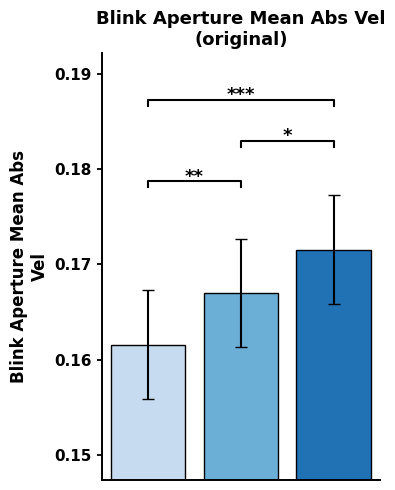

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for blink_aperture_rms:
  H: 0.042
  L: 0.041
  M: 0.042

=== original_blink_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -28976.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8827 -0.4511  0.0188  0.4385 14.7219 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 8.312e-05 0.009117
 Residual                   1.076e-04 0.010375
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            4.115e-02  4.156e-03  4.703e+01   9.901 4.38e-13 ***
condition.L            1.811e-03  3.849e-04  4.601e+03   4.705 2.62e-06 ***
condition.Q           -4.854e-04  3.862e-04  4.593e+03  -1.257    0.209    
session_order_numeric  1.3

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


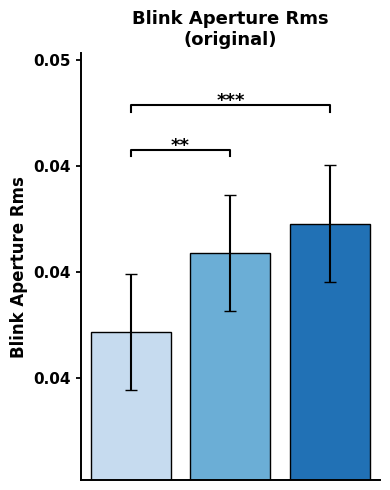

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4621' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4621' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for mouth_aperture_mean_abs_vel:
  H: 0.098
  L: 0.094
  M: 0.091

=== original_mouth_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -19661.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5582 -0.4995 -0.0806  0.3139  9.3864 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0005279 0.02298 
 Residual                   0.0007902 0.02811 
Number of obs: 4621, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.094e-01  1.050e-02  4.716e+01  10.424 7.91e-14 ***
condition.L            3.573e-03  1.044e-03  4.584e+03   3.423 0.000625 ***
condition.Q            3.679e-03  1.048e-03  4.575e+03   3.511 0.000451 ***
session_

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4621' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4621' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  


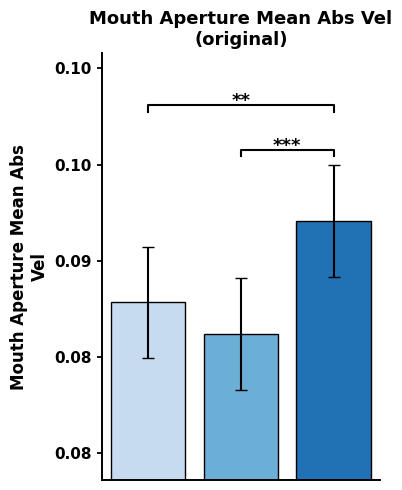

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4621' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4621' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for mouth_aperture_rms:
  H: 0.013
  L: 0.011
  M: 0.009

=== original_mouth_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -28624.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8475 -0.5476 -0.2119  0.1026  8.1940 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 7.374e-05 0.008587
 Residual                   1.134e-04 0.010649
Number of obs: 4621, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.513e-02  3.926e-03  4.715e+01   3.855  0.00035 ***
condition.L            1.639e-03  3.954e-04  4.584e+03   4.145 3.46e-05 ***
condition.Q            1.664e-03  3.971e-04  4.575e+03   4.192 2.82e-05 ***
session_order_numeric -2.9

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4621' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4621' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  


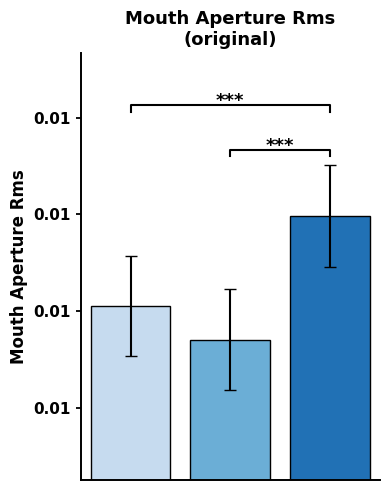

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4643' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4643)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4643' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4643)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for pupil_dx_rms:
  H: 0.005
  L: 0.005
  M: 0.005

=== original_pupil_dx_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -30192.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.4241 -0.1416 -0.0688 -0.0100 22.3902 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 9.900e-07 0.000995
 Residual                   8.584e-05 0.009265
Number of obs: 4643, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            4.906e-03  7.590e-04  5.724e+01   6.464 2.43e-08 ***
condition.L            1.608e-04  3.359e-04  3.219e+03   0.479    0.632    
condition.Q            2.166e-04  3.421e-04  4.511e+03   0.633    0.527    
session_order_numeric  1.828e-05  4.84

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4643' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4643)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4643' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4643)' or larger];
but be warned that this may result in large computation time and memory use.
  


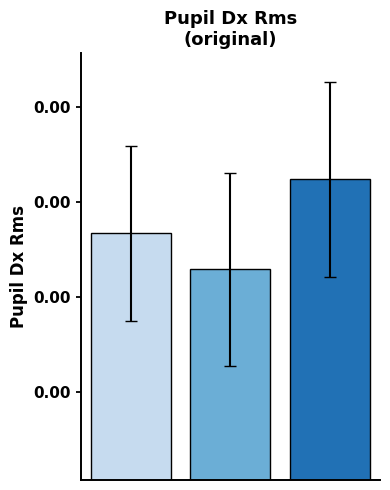

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4643' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4643)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4643' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4643)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for pupil_dy_rms:
  H: 0.014
  L: 0.013
  M: 0.012

=== original_pupil_dy_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -25009.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2109 -0.1546 -0.0644  0.0258 22.6902 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 1.011e-05 0.00318 
 Residual                   2.609e-04 0.01615 
Number of obs: 4643, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.200e-02  1.796e-03  4.459e+01   6.678 3.19e-08 ***
condition.L            9.935e-04  5.934e-04  4.555e+03   1.674   0.0942 .  
condition.Q            6.596e-04  5.992e-04  4.636e+03   1.101   0.2710    
session_order_numeric  6.439e-04  1.14

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4643' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4643)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4643' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4643)' or larger];
but be warned that this may result in large computation time and memory use.
  


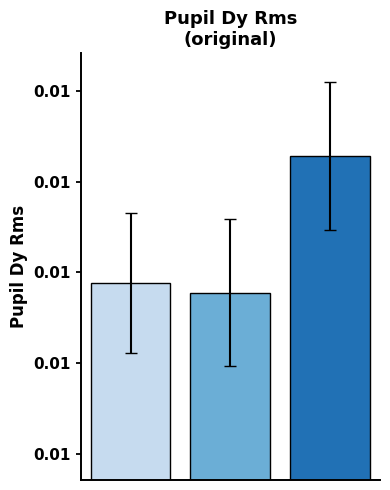

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4643' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4643)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4643' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4643)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for pupil_metric_rms:
  H: 0.009
  L: 0.009
  M: 0.007

=== original_pupil_metric_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -23477.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0055 -0.1384 -0.0682 -0.0027 20.6532 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 1.355e-05 0.003681
 Residual                   3.631e-04 0.019055
Number of obs: 4643, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)            7.114e-03  2.094e-03  4.492e+01   3.398  0.00143 **
condition.L            9.304e-04  6.999e-04  4.544e+03   1.329  0.18377   
condition.Q            7.084e-04  7.068e-04  4.637e+03   1.002  0.31626   
session_order_numeric  6.212e-04  

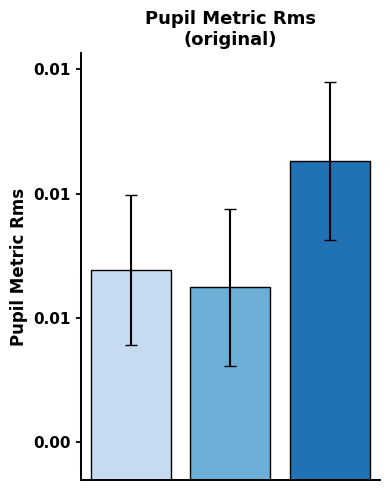

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4632' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4632)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4632' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4632)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for center_face_magnitude_rms:
  H: 0.124
  L: 0.123
  M: 0.118

=== original_center_face_magnitude_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -11632.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7703 -0.5268 -0.1411  0.3311 13.0735 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.001735 0.04165 
 Residual                   0.004552 0.06747 
Number of obs: 4632, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            8.892e-02  1.927e-02  4.689e+01   4.614 3.08e-05 ***
condition.L            6.684e-03  2.502e-03  4.603e+03   2.672  0.00758 ** 
condition.Q            1.373e-03  2.511e-03  4.589e+03   0.547  0.58453    
session_order_n

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4632' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4632)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4632' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4632)' or larger];
but be warned that this may result in large computation time and memory use.
  


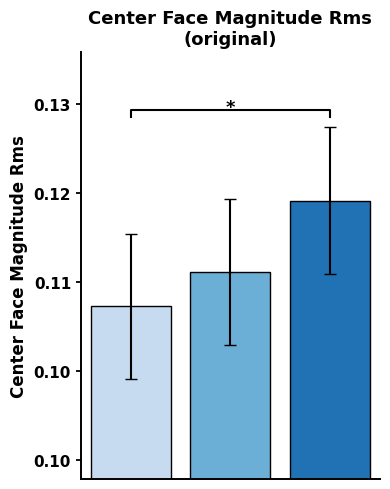

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4632' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4632)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4632' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4632)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for center_face_x_rms:
  H: 0.097
  L: 0.092
  M: 0.092

=== original_center_face_x_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -15473

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3849 -0.6023 -0.1385  0.3972 10.6384 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0009586 0.03096 
 Residual                   0.0019801 0.04450 
Number of obs: 4632, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            6.322e-02  1.424e-02  4.677e+01   4.440 5.46e-05 ***
condition.L            1.028e-02  1.651e-03  4.599e+03   6.224 5.26e-10 ***
condition.Q           -2.142e-03  1.656e-03  4.587e+03  -1.293  0.19590    
session_order_numeric  1.886e-

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4632' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4632)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4632' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4632)' or larger];
but be warned that this may result in large computation time and memory use.
  


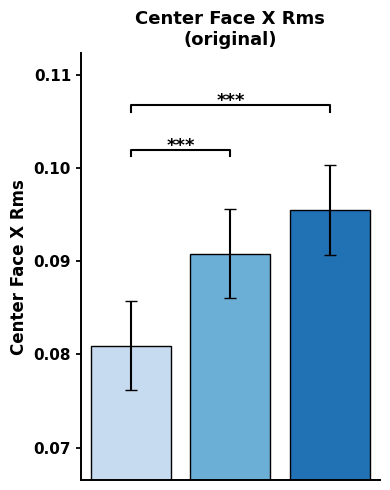

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4632' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4632)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4632' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4632)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for center_face_y_rms:
  H: 0.106
  L: 0.107
  M: 0.099

=== original_center_face_y_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -12897.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8552 -0.5142 -0.1358  0.2863 13.7072 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.001538 0.03922 
 Residual                   0.003458 0.05880 
Number of obs: 4632, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            8.289e-02  1.807e-02  4.700e+01   4.586 3.36e-05 ***
condition.L            3.111e-03  2.181e-03  4.601e+03   1.426   0.1538    
condition.Q            4.455e-03  2.188e-03  4.588e+03   2.036   0.0418 *  
session_order_numeric  1.350e-0

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4632' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4632)' or larger];
but be warned that this may result in large computation time and memory use.
  


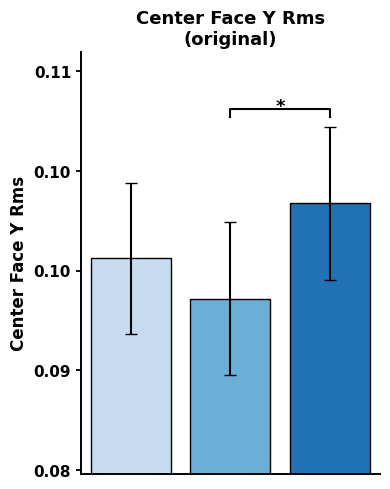

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4619' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4619' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr


Analyzing procrustes_global normalization method...
Means for head_rotation_rad_mean_abs_vel:
  H: 0.176
  L: 0.174
  M: 0.171

=== procrustes_global_head_rotation_rad_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -17634.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6664 -0.4867 -0.1088  0.2839 11.6739 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0007731 0.02780 
 Residual                   0.0012245 0.03499 
Number of obs: 4619, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.717e-01  1.272e-02  4.712e+01  13.499  < 2e-16 ***
condition.L            3.545e-03  1.300e-03  4.583e+03   2.726  0.00644 ** 
condition.Q     

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4619' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4619' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  


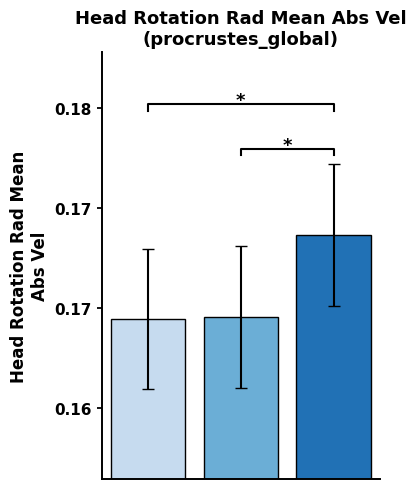

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4619' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4619' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for head_rotation_rad_rms:
  H: 0.039
  L: 0.037
  M: 0.041

=== procrustes_global_head_rotation_rad_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -21870.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7826 -0.4275 -0.1371  0.2015 13.9742 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0003646 0.01910 
 Residual                   0.0004881 0.02209 
Number of obs: 4619, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.985e-02  8.710e-03  4.713e+01   2.279  0.02722 *  
condition.L            2.689e-03  8.211e-04  4.581e+03   3.275  0.00107 ** 
condition.Q           -3.421e-03  8.235e-04  4.572e+03  -4.154 3.33e-05 ***
session_ord

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4619' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4619' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  


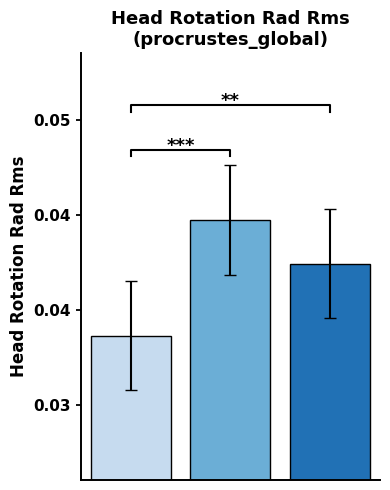

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for blink_aperture_mean_abs_vel:
  H: 0.182
  L: 0.176
  M: 0.179

=== procrustes_global_blink_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -16954.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5611 -0.5238 -0.0454  0.4619  6.4927 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.001927 0.04389 
 Residual                   0.001432 0.03785 
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.736e-01  1.988e-02  4.707e+01   8.732 2.08e-11 ***
condition.L            6.221e-03  1.404e-03  4.596e+03   4.430 9.66e-06 ***
condition.Q           -9.788e-04  1.409e-03  4.591e+03  -0.695    0.487    
se

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


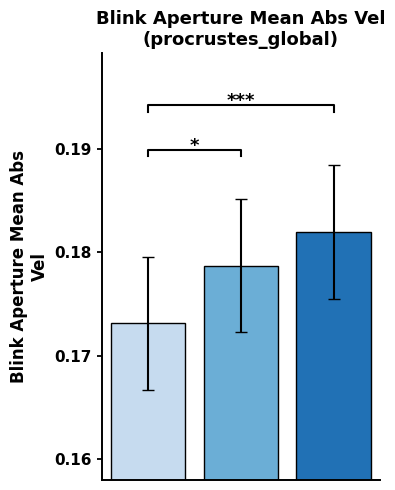

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for blink_aperture_rms:
  H: 0.043
  L: 0.042
  M: 0.043

=== procrustes_global_blink_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -29803.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9819 -0.5542 -0.0018  0.5334  4.2706 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0001136 0.010660
 Residual                   0.0000896 0.009466
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            4.266e-02  4.831e-03  4.699e+01   8.830 1.52e-11 ***
condition.L            1.471e-03  3.513e-04  4.596e+03   4.187 2.88e-05 ***
condition.Q           -5.329e-04  3.523e-04  4.591e+03  -1.513    0.130    
session_order_num

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


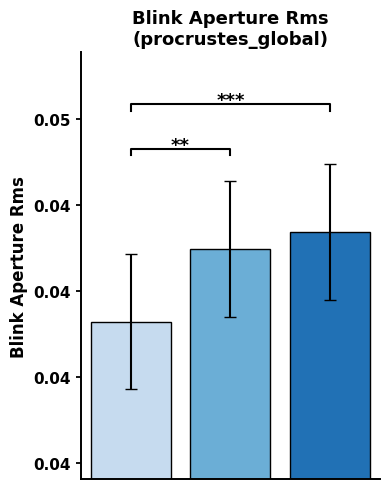

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4621' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4621' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for mouth_aperture_mean_abs_vel:
  H: 0.102
  L: 0.098
  M: 0.096

=== procrustes_global_mouth_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -19675.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6399 -0.5395 -0.0707  0.3540  8.1690 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0005825 0.02413 
 Residual                   0.0007870 0.02805 
Number of obs: 4621, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.141e-01  1.101e-02  4.709e+01  10.360 9.87e-14 ***
condition.L            3.557e-03  1.042e-03  4.583e+03   3.414 0.000645 ***
condition.Q            3.044e-03  1.046e-03  4.574e+03   2.910 0.003636 ** 

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4621' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4621' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  


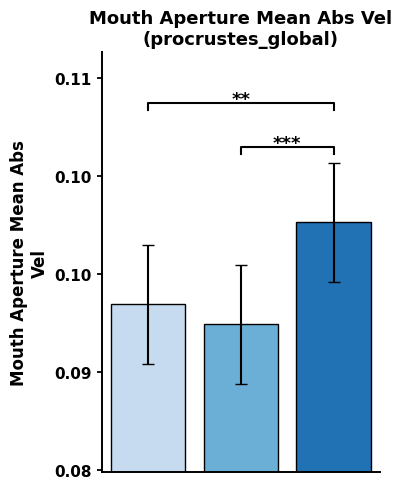

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4621' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4621' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for mouth_aperture_rms:
  H: 0.013
  L: 0.011
  M: 0.010

=== procrustes_global_mouth_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -28480.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6209 -0.5473 -0.2118  0.1045  8.6576 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 7.806e-05 0.008835
 Residual                   1.170e-04 0.010815
Number of obs: 4621, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.533e-02  4.037e-03  4.715e+01   3.798 0.000417 ***
condition.L            1.744e-03  4.016e-04  4.584e+03   4.341 1.45e-05 ***
condition.Q            1.650e-03  4.032e-04  4.575e+03   4.091 4.37e-05 ***
session_order_num

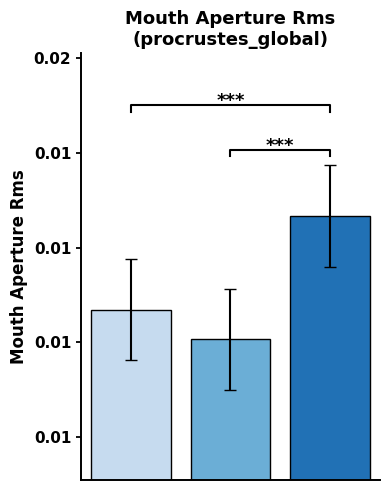

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for pupil_dx_rms:
  H: 0.005
  L: 0.005
  M: 0.005

=== procrustes_global_pupil_dx_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -35965.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2884 -0.1893 -0.0738  0.0381 26.7751 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 3.731e-06 0.001932
 Residual                   2.419e-05 0.004919
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)           4.385e-03  9.303e-04 4.658e+01   4.714 2.23e-05 ***
condition.L           3.660e-04  1.820e-04 4.629e+03   2.011 0.044371 *  
condition.Q           4.008e-04  1.829e-04 4.607e+03   2.191 0.028484 *  
session_order_numeric 4.751e-04  5.91

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


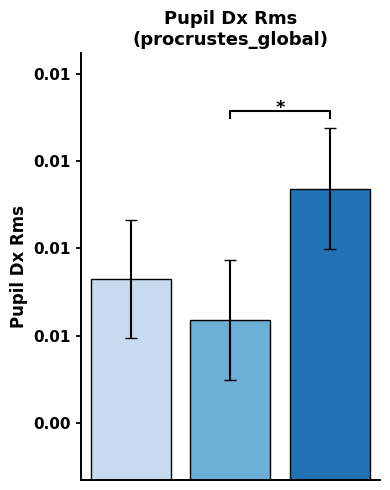

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for pupil_dy_rms:
  H: 0.013
  L: 0.013
  M: 0.013

=== procrustes_global_pupil_dy_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -36008.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4367 -0.3416 -0.0638  0.2173 23.4198 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 6.214e-06 0.002493
 Residual                   2.386e-05 0.004884
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)           1.245e-02  1.168e-03 4.697e+01  10.654 4.02e-14 ***
condition.L           3.303e-04  1.809e-04 4.619e+03   1.826    0.068 .  
condition.Q           4.104e-04  1.817e-04 4.601e+03   2.259    0.024 *  
session_order_numeric 4.182e-04  7.43

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


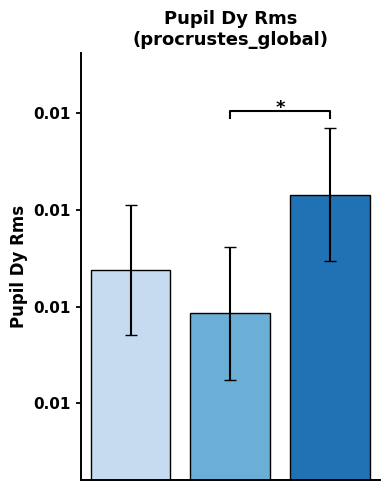

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for pupil_metric_rms:
  H: 0.008
  L: 0.008
  M: 0.007

=== procrustes_global_pupil_metric_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -32568.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2502 -0.2206 -0.0821  0.0508 25.8869 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 8.914e-06 0.002986
 Residual                   5.029e-05 0.007091
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)           6.765e-03  1.426e-03 4.671e+01   4.744 2.01e-05 ***
condition.L           4.248e-04  2.625e-04 4.627e+03   1.618   0.1056    
condition.Q           6.676e-04  2.637e-04 4.605e+03   2.531   0.0114 *  
session_order_numeric 6.006e-

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


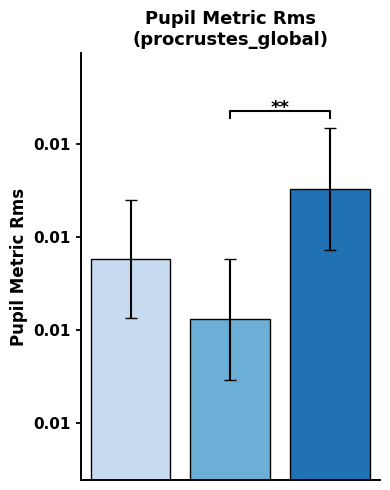

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4619' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4619' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr


Analyzing procrustes_participant normalization method...
Means for head_rotation_rad_mean_abs_vel:
  H: 0.175
  L: 0.173
  M: 0.171

=== procrustes_participant_head_rotation_rad_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -17733.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6461 -0.4894 -0.1063  0.2906 11.8221 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0007386 0.02718 
 Residual                   0.0011989 0.03462 
Number of obs: 4619, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.710e-01  1.244e-02  4.712e+01  13.751  < 2e-16 ***
condition.L            3.628e-03  1.287e-03  4.583e+03   2.820  0.00482 ** 
condit

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4619' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4619' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  


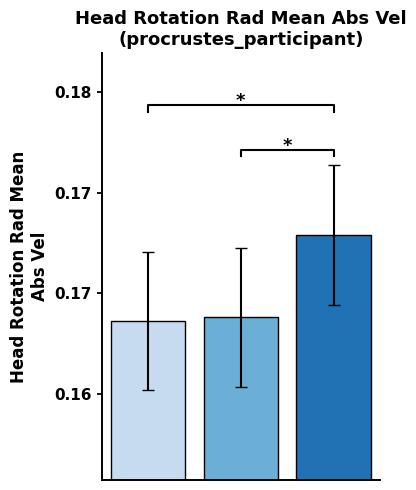

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4619' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4619' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for head_rotation_rad_rms:
  H: 0.038
  L: 0.037
  M: 0.040

=== procrustes_participant_head_rotation_rad_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -21806.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7261 -0.4264 -0.1401  0.1929 13.8065 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0003593 0.01895 
 Residual                   0.0004951 0.02225 
Number of obs: 4619, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.978e-02  8.650e-03  4.713e+01   2.287  0.02673 *  
condition.L            2.689e-03  8.269e-04  4.581e+03   3.252  0.00115 ** 
condition.Q           -3.374e-03  8.294e-04  4.572e+03  -4.068 4.83e-05 ***
sessio

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4619' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4619)' or larger];
but be warned that this may result in large computation time and memory use.
  


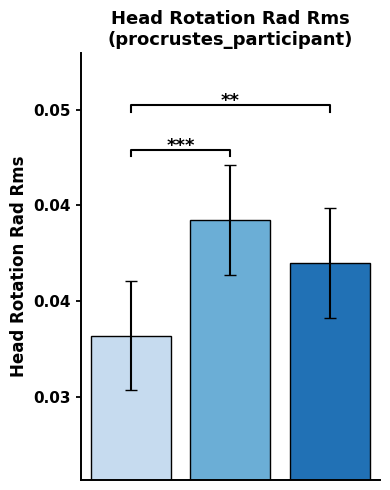

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for blink_aperture_mean_abs_vel:
  H: 0.172
  L: 0.167
  M: 0.169

=== procrustes_participant_blink_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -18142.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7040 -0.5558 -0.0318  0.4671  6.3473 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.001401 0.03743 
 Residual                   0.001109 0.03330 
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.637e-01  1.696e-02  4.709e+01   9.651 9.75e-13 ***
condition.L            6.161e-03  1.236e-03  4.596e+03   4.985 6.42e-07 ***
condition.Q           -1.108e-03  1.240e-03  4.591e+03  -0.894    0.371  

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


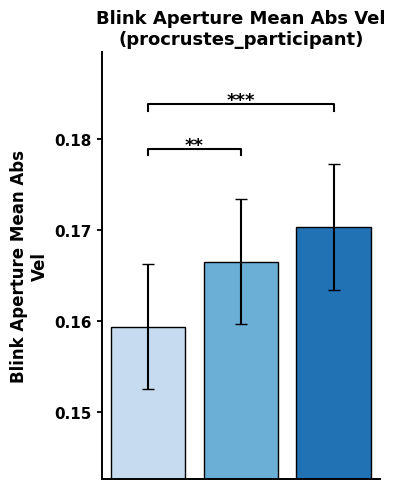

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for blink_aperture_rms:
  H: 0.041
  L: 0.040
  M: 0.040

=== procrustes_participant_blink_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -31122.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3608 -0.5428  0.0351  0.5783  3.5950 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 7.488e-05 0.008653
 Residual                   6.751e-05 0.008216
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            4.007e-02  3.927e-03  4.704e+01  10.204 1.65e-13 ***
condition.L            1.487e-03  3.049e-04  4.598e+03   4.878 1.11e-06 ***
condition.Q           -5.884e-04  3.058e-04  4.591e+03  -1.924   0.0544 .  
session_orde

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


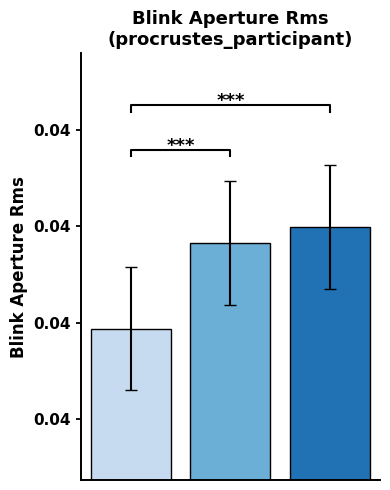

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4621' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4621' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for mouth_aperture_mean_abs_vel:
  H: 0.097
  L: 0.094
  M: 0.091

=== procrustes_participant_mouth_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -19928.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5643 -0.4936 -0.0712  0.3124  9.4166 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0005206 0.02282 
 Residual                   0.0007455 0.02730 
Number of obs: 4621, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.097e-01  1.042e-02  4.715e+01  10.525 5.75e-14 ***
condition.L            3.485e-03  1.014e-03  4.583e+03   3.437 0.000594 ***
condition.Q            2.962e-03  1.018e-03  4.574e+03   2.909 0.00364

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4621' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4621' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  


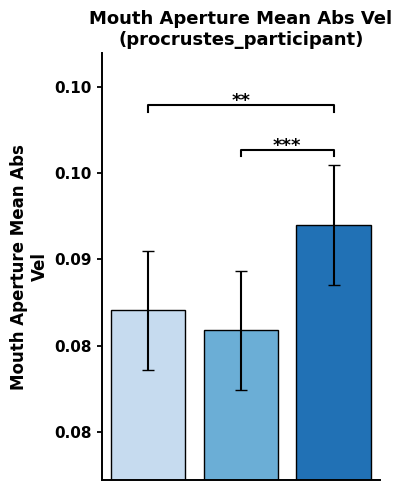

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4621' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4621' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for mouth_aperture_rms:
  H: 0.012
  L: 0.011
  M: 0.009

=== procrustes_participant_mouth_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -28799.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9127 -0.5488 -0.2127  0.1037  8.2794 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 7.229e-05 0.008502
 Residual                   1.092e-04 0.010448
Number of obs: 4621, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.511e-02  3.886e-03  4.715e+01   3.890 0.000314 ***
condition.L            1.667e-03  3.880e-04  4.584e+03   4.297 1.77e-05 ***
condition.Q            1.576e-03  3.896e-04  4.575e+03   4.047 5.28e-05 ***
session_orde

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4621' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4621' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4621)' or larger];
but be warned that this may result in large computation time and memory use.
  


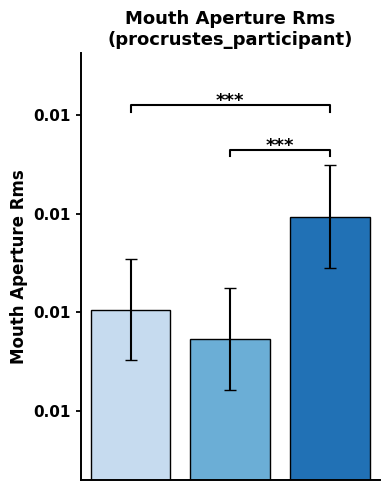

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for pupil_dx_rms:
  H: 0.005
  L: 0.005
  M: 0.005

=== procrustes_participant_pupil_dx_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -37253.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2165 -0.1920 -0.0788  0.0330 25.8306 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 2.542e-06 0.001594
 Residual                   1.834e-05 0.004283
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)           4.225e-03  7.734e-04 4.666e+01   5.463 1.77e-06 ***
condition.L           3.002e-04  1.584e-04 4.631e+03   1.895   0.0581 .  
condition.Q           3.458e-04  1.592e-04 4.608e+03   2.171   0.0300 *  
session_order_numeric 3.872e-04 

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


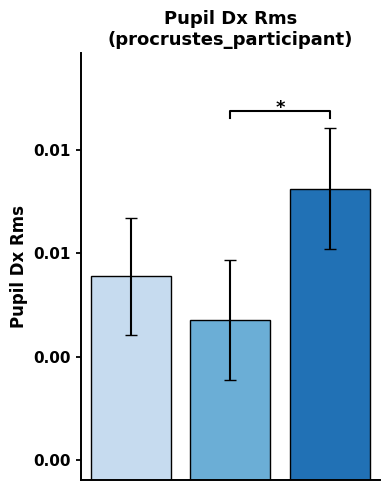

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for pupil_dy_rms:
  H: 0.013
  L: 0.012
  M: 0.012

=== procrustes_participant_pupil_dy_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -37034.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3255 -0.3487 -0.0596  0.2140 23.1537 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 3.633e-06 0.001906
 Residual                   1.918e-05 0.004379
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)           1.190e-02  9.069e-04 4.708e+01  13.117   <2e-16 ***
condition.L           3.043e-04  1.621e-04 4.625e+03   1.877   0.0606 .  
condition.Q           3.804e-04  1.629e-04 4.604e+03   2.336   0.0196 *  
session_order_numeric 3.291e-04 

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


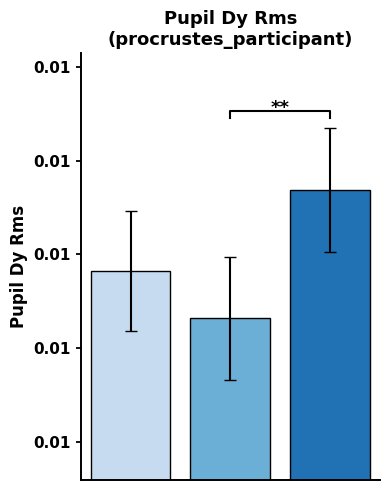

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: 2: Some predictor variables are on very different scales: consider rescaling 
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback wr

Means for pupil_metric_rms:
  H: 0.008
  L: 0.007
  M: 0.007

=== procrustes_participant_pupil_metric_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -33688

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1703 -0.2328 -0.0822  0.0548 25.2007 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 6.206e-06 0.002491
 Residual                   3.954e-05 0.006288
Number of obs: 4640, groups:  participant_id, 49

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            6.458e-03  1.198e-03  4.680e+01   5.389 2.26e-06 ***
condition.L            3.435e-04  2.327e-04  4.629e+03   1.476    0.140    
condition.Q            5.945e-04  2.338e-04  4.607e+03   2.543    0.011 *  
session_order_nume

R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 4640' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  
R callback write-console: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 4640' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 4640)' or larger];
but be warned that this may result in large computation time and memory use.
  


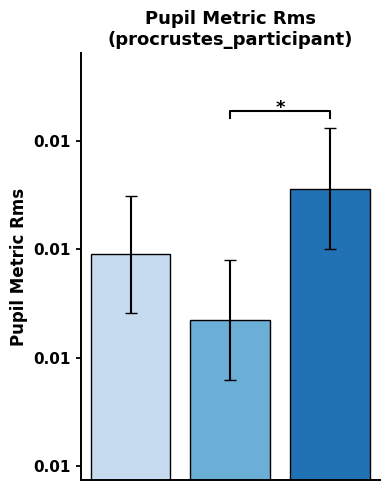


Analysis complete! Processed 30 metrics total


In [5]:
# Filter methods if user selected a subset
methods_to_analyze = pose_metrics_df["method"].unique()
results = {}

for method in methods_to_analyze:
    df_method = pose_metrics_df[pose_metrics_df["method"] == method]
    print(f"\nAnalyzing {method} normalization method...")
    results[method] = {}

    for metric in metric_cols:
        # Skip if column doesn't exist
        if metric not in df_method.columns:
            continue
        # Skip if column is all NaN
        if df_method[metric].dropna().empty:
            continue

        label = metric.replace("_", " ").title()
        pvals, means, cis = run_rpy2_lmer(df_method, metric, f"{method}_{metric}")

        if pvals is not None:
            results[method][metric] = {
                "pvals": pvals,
                "means": means,
                "cis": cis,
                "label": label
            }

            # Plots
            conds = ["L", "M", "H"]
            mean_vals = [means.get(c, float('nan')) for c in conds]
            sems = [(cis[c][1] - cis[c][0]) / 3.92 if c in cis else float('nan') for c in conds]
            pval_list = [
                pvals.get(("L", "M"), 1.0),
                pvals.get(("L", "H"), 1.0),
                pvals.get(("M", "H"), 1.0)
            ]

            fig, ax = plt.subplots(figsize=(4, 5))
            barplot_ax(ax, mean_vals, sems, pval_list, ylabel=label, metric_name=metric)
            ax.set_title(f"{label}\n({method})", fontsize=13, weight='bold')
            plt.tight_layout()
            plt.show()

print(f"\nAnalysis complete! Processed {sum(len(r) for r in results.values())} metrics total")